# Import des librairies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import imblearn

# Import des données

In [2]:
df = pd.read_csv('donnée/data_rdy.csv')

# Préparation des données

In [3]:
train_df = df[df['TARGET'].notnull()]

# Destiné à Kaggle
test_df = df[df['TARGET'].isnull()]

In [4]:
# On retire les informations qui ne sont pas des features

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

correlation = train_df[feats].corrwith(train_df['TARGET'])

feature = list(correlation.abs().sort_values(ascending=False)[:20].index)

train_rdy = train_df.dropna(subset = feature)
train_rdy

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
36,36,100043,0.0,1,0,0,2,198000.0,641173.5,23157.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,33.0
85,85,100100,0.0,0,1,0,2,202500.0,796396.5,38443.5,...,1.0,0.031915,3.0,0.031229,0.0,0.0,0.0,0.0,0.0,94.0
111,111,100131,0.0,1,0,0,0,270000.0,891072.0,45625.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,24.0
119,119,100139,0.0,1,0,1,1,157500.0,302341.5,24016.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,75.0
124,124,100145,0.0,1,1,0,1,202500.0,260725.5,16789.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307469,307473,456213,0.0,1,1,0,1,90000.0,258709.5,20439.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,34.0
307471,307475,456215,1.0,1,0,1,1,144000.0,1303200.0,46809.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,94.0
307475,307479,456219,0.0,1,0,0,1,112500.0,521280.0,31630.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,10.0
307496,307500,456244,0.0,1,0,0,0,261000.0,1303812.0,35982.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,41.0


In [6]:
# On prend un sample des données pour gagner du temps

#train_rdy_sample = train_rdy.sample(frac=0.3,random_state=0)

In [7]:
# On vérifie que l'imbalance est bien conservé

#dict(train_rdy_sample['TARGET'].value_counts()/len(train_rdy_sample['TARGET'])*100)

In [8]:
# On récupère notre x et notre y

X = train_rdy[feature]
y = train_rdy[['TARGET']]

In [22]:
from sklearn.model_selection import train_test_split

# On prend un X_train et y_train

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 0)

In [27]:
# On prend un sample des données pour gagner du temps

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_train,y_train,train_size=0.4,random_state = 0)

In [28]:
X_train_sample.shape

(3018, 20)

In [29]:
# On vérifie que l'imbalance est bien conservé

dict(y_train_sample['TARGET'].value_counts()/len(y_train_sample['TARGET'])*100)

{0.0: 90.15904572564612, 1.0: 9.840954274353876}

# Fine tuning

In [30]:
# Score
from sklearn.metrics import fbeta_score, make_scorer, roc_auc_score

#Pipeline
from imblearn.pipeline import Pipeline

# Gridsearch

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Logistic regression

from sklearn.linear_model import LogisticRegression

# SMOTE pour le sampling

from imblearn.over_sampling import SMOTE

# On prépare le fbetascore pour le gridsearch

# Le fbeta_score permet de maximiser la pénalité sur les faux négatifs. Il servira à évaluer la performance final de nos modèles
ftwo_scorer = make_scorer(fbeta_score, beta=10)

# On prépare le roc_auc_score pour le gridsearch

roc_auc = make_scorer(roc_auc_score)

In [31]:
# Commençons par faire fonctionner notre modèle avec les paramètres d'origine

model_logistic = Pipeline([
        ('sampling', SMOTE()),
        ('classification', LogisticRegression())
        ])
    
param_orig = {'classification__tol': [0.0009326033468832199],
                'classification__solver': ['liblinear'],
                'classification__penalty': ['l1'],
                'classification__max_iter': [1000],
                'classification__C': [18589.56679635688]}
    
search_logi_ftwo_o = RandomizedSearchCV(estimator = model_logistic,scoring = ftwo_scorer,\
                               param_distributions =param_orig, n_iter = 20, cv = 5,\
                               verbose=2, random_state=0, n_jobs = -1)

In [32]:
search_logi_ftwo_o.fit(X_train_sample,y_train_sample)

C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling', SMOTE()),
                                             ('classification',
                                              LogisticRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classification__C': [18589.56679635688],
                                        'classification__max_iter': [1000],
                                        'classification__penalty': ['l1'],
                                        'classification__solver': ['liblinear'],
                                        'classification__tol': [0.0009326033468832199]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=10),
                   verbose=2)

In [33]:
current_model = search_logi_ftwo_o

y_predict = current_model.predict(X_test)

report_final = pd.DataFrame({'model':'search_gradiant','score':['ftwo'],'best_params':[current_model.best_params_],\
          'best_score':[current_model.best_score_],'train':[current_model.score(X_train, y_train)],\
          'test':[current_model.score(X_test, y_test)],'fbeta_score_test':[fbeta_score(y_test,y_predict,beta=10)]})

report_final

# Par erreur, on a appellé le modèle search_gradiant au lieu de search_logi

,model,score,best_params,best_score,train,test,fbeta_score_test
0,search_gradiant,ftwo,"{'classification__tol': 0.0009326033468832199,...",0.61348,0.644248,0.624637,0.624637


In [34]:
# Essayons de nouveau paramètre

model_logistic = Pipeline([
        ('sampling', SMOTE()),
        ('classification', LogisticRegression())
    ])

random_grid = {'classification__tol': np.logspace(-4, -2, 100),
                'classification__solver': ['liblinear'],
                'classification__penalty': ['l1'],
                'classification__max_iter': [900,1000,1100,1200,1300,1400,1500],
                'classification__C': np.logspace(-5, 5,1000)
              }

search_logi_ftwo = RandomizedSearchCV(estimator = model_logistic,scoring = ftwo_scorer,\
                               param_distributions =random_grid, n_iter = 100, cv = 5,\
                               verbose=2, random_state=0, n_jobs = -1)

In [35]:
search_logi_ftwo.fit(X_train_sample,y_train_sample)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling', SMOTE()),
                                             ('classification',
                                              LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classification__C': array([1.00000000e-05, 1.02331658e-05, 1.04717682e-05, 1.07159340e-05,
       1.09657929e-05, 1.12214777e-05, 1.14831241e-05, 1.17508713e-05,
       1.20248614e-05, 1.23052400e-05, 1.25921561e-05, 1.2...
       0.00259502, 0.00271859, 0.00284804, 0.00298365, 0.00312572,
       0.00327455, 0.00343047, 0.00359381, 0.00376494, 0.00394421,
       0.00413201, 0.00432876, 0.00453488, 0.00475081, 0.00497702,
       0.00521401, 0.00546228, 0.00572237, 0.00599484, 0.00628029,
       0.00657933, 0.00689261, 0.00722081, 0.00756463, 0.00792483,
       0.00830218, 0.00869749, 0.00911163, 0.00954548, 0.01      ])},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=10),
                   verbose=2)

In [36]:
search_logi_ftwo.best_params_


{'classification__tol': 0.0022570197196339213,
 'classification__solver': 'liblinear',
 'classification__penalty': 'l1',
 'classification__max_iter': 1300,
 'classification__C': 2389.8925662310526}

In [37]:
best_param = {'classification__tol': [0.0022570197196339213],
                'classification__solver': ['liblinear'],
                'classification__penalty': ['l1'],
                'classification__max_iter': [1500],
                'classification__C': [49.73895958790068]}


In [38]:
current_model = search_logi_ftwo

y_predict = current_model.predict(X_test)

report_new = pd.DataFrame({'model':'search_gradiant','score':['ftwo'],'best_params':[current_model.best_params_],\
          'best_score':[current_model.best_score_],'train':[current_model.score(X_train, y_train)],\
          'test':[current_model.score(X_test, y_test)],'fbeta_score_test':[fbeta_score(y_test,y_predict,beta=10)]})

report_final = pd.concat([report_final,report_new])
report_final

# Par erreur, on a appellé le modèle search_gradiant au lieu de search_logi
# Par erreur le score fbeta a été appellé ftwo

,model,score,best_params,best_score,train,test,fbeta_score_test
0,search_gradiant,ftwo,"{'classification__tol': 0.0009326033468832199,...",0.613480,0.644248,0.624637,0.624637
0,search_gradiant,ftwo,"{'classification__tol': 0.0022570197196339213,...",0.626346,0.654305,0.662170,0.662170


In [39]:
#Essayons avec roc_auc

search_logi_roc = RandomizedSearchCV(estimator = model_logistic,scoring = roc_auc,\
                               param_distributions =random_grid, n_iter = 100, cv = 5,\
                               verbose=2, random_state=0, n_jobs = -1)

In [40]:
search_logi_roc.fit(X_train_sample,y_train_sample)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling', SMOTE()),
                                             ('classification',
                                              LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classification__C': array([1.00000000e-05, 1.02331658e-05, 1.04717682e-05, 1.07159340e-05,
       1.09657929e-05, 1.12214777e-05, 1.14831241e-05, 1.17508713e-05,
       1.20248614e-05, 1.23052400e-05, 1.25921561e-05, 1.2...
       0.00259502, 0.00271859, 0.00284804, 0.00298365, 0.00312572,
       0.00327455, 0.00343047, 0.00359381, 0.00376494, 0.00394421,
       0.00413201, 0.00432876, 0.00453488, 0.00475081, 0.00497702,
       0.00521401, 0.00546228, 0.00572237, 0.00599484, 0.00628029,
       0.00657933, 0.00689261, 0.00722081, 0.00756463, 0.00792483,
       0.00830218, 0.00869749, 0.00911163, 0.00954548, 0.01      ])},
                   random_state=0, scoring=make_scorer(roc_auc_score),
                   verbose=2)

In [41]:
search_logi_roc.best_params_

{'classification__tol': 0.0016297508346206436,
 'classification__solver': 'liblinear',
 'classification__penalty': 'l1',
 'classification__max_iter': 1300,
 'classification__C': 465.2299523960189}

In [44]:
best_param_roc = {'classification__tol': [0.0016297508346206436],
                'classification__solver': ['liblinear'],
                'classification__penalty': ['l1'],
                'classification__max_iter': [1300],
                'classification__C': [465.2299523960189]}


In [43]:
current_model = search_logi_roc

y_predict = current_model.predict(X_test)

report_new = pd.DataFrame({'model':'search_gradiant','score':['roc'],'best_params':[current_model.best_params_],\
          'best_score':[current_model.best_score_],'train':[current_model.score(X_train, y_train)],\
          'test':[current_model.score(X_test, y_test)],'fbeta_score_test':[fbeta_score(y_test,y_predict,beta=10)]})

report_final = pd.concat([report_final,report_new])
report_final

# Par erreur, on a appellé le modèle search_gradiant au lieu de search_logi
# Par erreur, on a appellé le roc ftwo. C'est celui qui est à la troisième ligne. Il a été refait avec l'appellation correcte
# à la quatrième ligne
# Par erreur le score fbeta a été appellé ftwo

,model,score,best_params,best_score,train,test,fbeta_score_test
0,search_gradiant,ftwo,"{'classification__tol': 0.0009326033468832199,...",0.613480,0.644248,0.624637,0.624637
0,search_gradiant,ftwo,"{'classification__tol': 0.0022570197196339213,...",0.626346,0.654305,0.662170,0.662170
0,search_gradiant,ftwo,"{'classification__tol': 0.0016297508346206436,...",0.655095,0.664117,0.667156,0.630892
0,search_gradiant,roc,"{'classification__tol': 0.0016297508346206436,...",0.655095,0.664117,0.667156,0.630892


# Fine tune sur le X_train complet

In [50]:
search_logi_fwto_final = RandomizedSearchCV(estimator = model_logistic,scoring = ftwo_scorer,\
                               param_distributions =best_param, n_iter = 20, cv = 5,\
                               verbose=2, random_state=0, n_jobs = -1)

In [47]:
search_logi_roc_final = RandomizedSearchCV(estimator = model_logistic,scoring = roc_auc,\
                               param_distributions =best_param_roc, n_iter = 20, cv = 5,\
                               verbose=2, random_state=0, n_jobs = -1)

In [51]:
search_logi_fwto_final.fit(X_train,y_train)

C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling', SMOTE()),
                                             ('classification',
                                              LogisticRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classification__C': [49.73895958790068],
                                        'classification__max_iter': [1500],
                                        'classification__penalty': ['l1'],
                                        'classification__solver': ['liblinear'],
                                        'classification__tol': [0.0022570197196339213]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=10),
                   verbose=2)

In [48]:
search_logi_roc_final.fit(X_train,y_train)

C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling', SMOTE()),
                                             ('classification',
                                              LogisticRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classification__C': [465.2299523960189],
                                        'classification__max_iter': [1300],
                                        'classification__penalty': ['l1'],
                                        'classification__solver': ['liblinear'],
                                        'classification__tol': [0.0016297508346206436]},
                   random_state=0, scoring=make_scorer(roc_auc_score),
                   verbose=2)

In [52]:
current_model = search_logi_fwto_final

y_predict = current_model.predict(X_test)

report_new_1 = pd.DataFrame({'model':'search_gradiant','score':['fwto'],'best_params':[current_model.best_params_],\
          'best_score':[current_model.best_score_],'train':[current_model.score(X_train, y_train)],\
          'test':[current_model.score(X_test, y_test)],'fbeta_score_test':[fbeta_score(y_test,y_predict,beta=10)]})

#report_final = pd.concat([report_final,report_new])
#report_final

report_new_1

# Par erreur, on a appellé le modèle search_gradiant au lieu de search_logi
# Par erreur le score fbeta a été appellé ftwo

,model,score,best_params,best_score,train,test,fbeta_score_test
0,search_gradiant,fwto,"{'classification__tol': 0.0022570197196339213,...",0.637733,0.648908,0.63121,0.63121


In [49]:
current_model = search_logi_roc_final

y_predict = current_model.predict(X_test)

report_new_1 = pd.DataFrame({'model':'search_gradiant','score':['roc'],'best_params':[current_model.best_params_],\
          'best_score':[current_model.best_score_],'train':[current_model.score(X_train, y_train)],\
          'test':[current_model.score(X_test, y_test)],'fbeta_score_test':[fbeta_score(y_test,y_predict,beta=10)]})

#report_final = pd.concat([report_final,report_new])
#report_final

report_new_1

# Par erreur, on a appellé le modèle search_gradiant au lieu de search_logi
# Par erreur le score fbeta a été appellé ftwo

,model,score,best_params,best_score,train,test,fbeta_score_test
0,search_gradiant,roc,"{'classification__tol': 0.0016297508346206436,...",0.669061,0.670158,0.672751,0.637546


In [54]:
# Le roc_auc semble être celui qui overfit le moins

# Fine tune Threshold

In [ ]:
# On fait quelques tests pour voir l'effet du threshold sur notre score final.

In [59]:
prediction_test = pd.DataFrame(search_logi_roc_final.predict_proba(X_test))[1]

In [60]:
def threshold_test(threshold,prediction):
    return  np.array(prediction.apply(lambda x : 1 if (x >= threshold)else 0))


In [62]:
score = []

for i in np.linspace(0,1,11):
    print('threshold :\n', i)
    print(fbeta_score(y_test,threshold_test(i,prediction_test),beta = 10),'\n')
    score.append(fbeta_score(y_test,threshold_test(i,prediction_test),beta = 10))

threshold :
 0.0
0.898460818165857 

threshold :
 0.1
0.9017857142857143 

threshold :
 0.2
0.8916194452728899 

threshold :
 0.30000000000000004
0.8242889335525914 

threshold :
 0.4
0.7402484472049689 

threshold :
 0.5
0.6375457644236839 

threshold :
 0.6000000000000001
0.505 

threshold :
 0.7000000000000001
0.3146213251995587 

threshold :
 0.8
0.17183614710116477 

threshold :
 0.9
0.03982649842271293 

threshold :
 1.0
0.0 



Text(0, 0.5, 'Score')

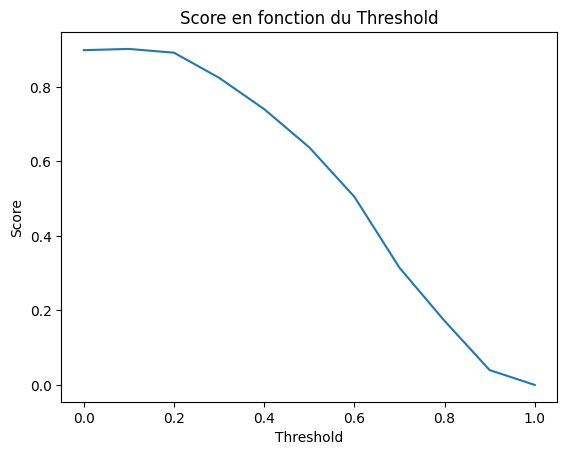

In [68]:
plt.plot(np.linspace(0,1,11),score)

plt.title('Score en fonction du Threshold')

plt.xlabel('Threshold')
plt.ylabel('Score')


# Sauvegarde du modèle

In [69]:
import joblib

In [70]:
joblib.dump(search_logi_roc_final, 'Pipeline\search_logi_roc_tuned.joblib')

['Pipeline\\search_logi_roc_tuned.joblib']